In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby

In [3]:
char_list=['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [4]:
char_list=sorted(char_list)
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

In [ ]:
!pip install --upgrade tensorflow


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
!apt list --installed | grep cudnn



libcudnn8-dev/unknown,now 8.9.6.50-1+cuda12.2 amd64 [installed,upgradable to: 8.9.7.29-1+cuda12.2]
libcudnn8/unknown,now 8.9.6.50-1+cuda12.2 amd64 [installed,upgradable to: 8.9.7.29-1+cuda12.2]


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

1/1 [==============================] - 2s 2s/step
Predicted text: ['likely']


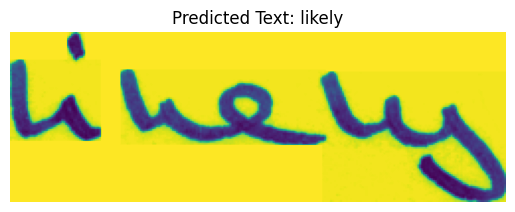

In [15]:
from tensorflow.keras.models import load_model
# Define the CTCLayer class
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# Define the ctc_decoder function
def ctc_decoder(predictions):
    text_list = []
    pred_indices = np.argmax(predictions, axis=2)
    for i in range(pred_indices.shape[0]):
        ans = ""
        merged_list = [k for k, _ in groupby(pred_indices[i])]
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        text_list.append(ans)
    return text_list

def load_and_predict(image_path, model_path):
    # Load the image
    img = tf.io.read_file(image_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])

    # Add batch dimension
    img = tf.expand_dims(img, axis=0)

    custom_objects = {'CTCLayer': CTCLayer}

    # Load the model with the custom object scope
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = load_model(model_path, compile=False)

    # Perform prediction
    # Define the prediction model
    prediction_model = Model(inputs=model.get_layer('image').input, outputs=model.get_layer('dense').output)

    # Now you can use this inference model for prediction
    predictions = prediction_model.predict(img)

    # Decode the predictions to get the predicted text
    predicted_text = ctc_decoder(predictions)

    print("Predicted text:", predicted_text)

    return predicted_text[0]

# Paths to the image and the trained model
image_path = "/content/a01-003u-02-02.png"
model_path = "/content/drive/MyDrive/best_model.h5"

# Load and predict
predicted_text = load_and_predict(image_path, model_path)

# Display the image with the predicted text
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted Text: {predicted_text}")
plt.axis('off')
plt.show()
